# Global analysis
For gps+argos, drogued, <25km, <30min

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import bootstrap

import dask.dataframe as dd
import os
from glob import glob

import matplotlib.pyplot as plt

import matplotlib.transforms as mtransforms

import histlib.matchup as match
from  histlib.diagnosis import build_matchup_dataframe, synthetic_figure, path_csv, put_fig_letter, lonlat_stats
from histlib.cstes import labels, zarr_dir, matchup_dir, c0

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
DL, DT = 25e3, 30*60
# if not already generated
comb_av_d = {'acc':'drifter_acc_x_25', 'cor':'drifter_coriolis_x_25', 'ggx':'aviso_drifter_ggx_adt', 'wd':'es_cstrio_z15_drifter_wd_x'}
comb_av_al = {'acc':'drifter_acc_x_25', 'cor':'drifter_coriolis_x_25', 'ggx':'aviso_drifter_ggx_adt', 'wd':'es_cstrio_z15_alti_wd_x'}
comb_alg = {'acc':'drifter_acc_x_25','cor':'drifter_coriolis_x_25','ggx':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wd':'es_cstrio_z15_drifter_wd_x'}

#df_av_d = build_matchup_dataframe(comb_av_d, 'both', True, DL, DT, store=True)
#df_av_al = build_matchup_dataframe(comb_av_al, 'both', True, DL, DT, store=True)
#df_alg = build_matchup_dataframe(comb_alg, 'both', True, DL, DT, store=True)

df_av_d = dd.read_csv(path_csv(comb_av_d, 'both', True, DL, DT)).repartition(npartitions=10).persist()
df_av_al = dd.read_csv(path_csv(comb_av_al, 'both', True, DL, DT))
df_alg = dd.read_csv(path_csv(comb_alg, 'both', True, DL, DT)).repartition(npartitions=10).persist()

In [31]:
def global_stast(df):
    from histlib.cstes import U
    #Mean
    mean = df.mean().compute()
    nb_coloc = len(df)
    mean['nb_coloc'] = nb_coloc

    #Central limit theorem
    errors = (2*df.std()/np.sqrt(nb_coloc)).compute()

    df = pd.DataFrame([mean, errors],index=['value','errors']).transpose()/(U**2)

    df['percentage']= df.value/df.value.sigma *100
    df['percentage_erros']= df.percentage * np.sqrt((df.errors/df.value)**2 +(df.errors.sigma/df.value.sigma)**2)

    return df

_________________
# Along-track

In [32]:
DL, DT = 25e3, 30*60
comb_alg = {'acc':'drifter_acc_x_25','cor':'drifter_coriolis_x_25','ggx':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wd':'es_cstrio_z15_drifter_wd_x'}
df_alg = dd.read_csv(path_csv(comb_alg, 'both', True, DL, DT)).repartition(npartitions=10)

In [33]:
len(df_alg)

239203

In [34]:
dfalg = global_stast(df_alg)
dfalg

,value,errors,percentage,percentage_erros
obs,5.750261e+14,2.090045e+12,6.858768e+15,7.755345e+13
acc,3.906361e+02,4.228043e+02,4.659411e+03,5.043352e+03
cor,-2.229967e+02,8.182263e+02,-2.659850e+03,-9.759641e+03
drogue_status,1.039111e+10,0.000000e+00,1.239426e+11,1.327064e+09
ggx,1.970851e+03,7.609455e+02,2.350782e+04,9.079858e+03
wd,-1.304171e+02,1.715550e+02,-1.555583e+03,-2.046334e+03
alti___distance,1.326366e+14,2.974264e+11,1.582056e+15,1.730673e+13
alti___time_difference,9.049134e+12,2.209272e+10,1.079358e+14,1.185341e+12
lat,4.097575e+10,1.680418e+09,4.887485e+11,2.071548e+10
lon,-1.165983e+11,4.384160e+09,-1.390756e+12,-5.437201e+10


_________________
# AVISO drifter

In [35]:
DL, DT = 25e3, 30*60
comb_av_d = {'acc':'drifter_acc_x_25', 'cor':'drifter_coriolis_x_25', 'ggx':'aviso_drifter_ggx_adt', 'wd':'es_cstrio_z15_drifter_wd_x'}
df_av_d = dd.read_csv(path_csv(comb_av_d, 'both', True, DL, DT)).repartition(npartitions=10).persist()

In [36]:
len(df_av_d)

238169

In [37]:
dfd = global_stast(df_av_d)
dfd

,value,errors,percentage,percentage_erros
obs,5.745718e+14,2.092100e+12,8.173280e+15,9.528095e+13
acc,4.052289e+02,4.229353e+02,5.764379e+03,6.016589e+03
cor,-3.581029e+02,8.190157e+02,-5.094012e+03,-1.165063e+04
drogue_status,1.039111e+10,0.000000e+00,1.478135e+11,1.636944e+09
ggx,2.656450e+02,5.895306e+02,3.778797e+03,8.386173e+03
wd,-1.255539e+02,1.721115e+02,-1.786004e+03,-2.448364e+03
alti___distance,1.326108e+14,2.981045e+11,1.886387e+15,2.131663e+13
alti___time_difference,9.048973e+12,2.214287e+10,1.287216e+14,1.459897e+12
lat,3.953271e+10,1.682526e+09,5.623526e+11,2.473089e+10
lon,-1.171412e+11,4.396924e+09,-1.666333e+12,-6.521169e+10


_________________
# AVISO alti

In [9]:
DL, DT = 25e3, 30*60
comb_av_a = {'acc':'drifter_acc_x_25', 'cor':'drifter_coriolis_x_25', 'ggx':'aviso_alti_ggx_adt', 'wd':'es_cstrio_z15_drifter_wd_x'}
df_av_a = dd.read_csv(path_csv(comb_av_a, 'both', True, DL, DT)).repartition(npartitions=10).persist()

In [10]:
len(df_av_a)

238552

In [11]:
dfa = global_stast(df_av_a)
dfa

,value,errors
obs,5.746562e+14,2.091153e+12
acc,4.300143e+02,4.227919e+02
cor,-3.454547e+02,8.187825e+02
drogue_status,1.039111e+10,0.000000e+00
ggx,4.651135e+02,5.936296e+02
wd,-1.275473e+02,1.719256e+02
alti___distance,1.326408e+14,2.978425e+11
alti___time_difference,9.049061e+12,2.212368e+10
lat,4.010998e+10,1.682038e+09
lon,-1.170695e+11,4.392036e+09


In [1]:
pwd

'/home1/datahome/mdemol/historical_analysis/2_both_GPS_ARGOS_drogued'

________________
# Synthetic figures

8.383810273600547
8.616672494488125
7.06578034776425
ok
7.298903015963676


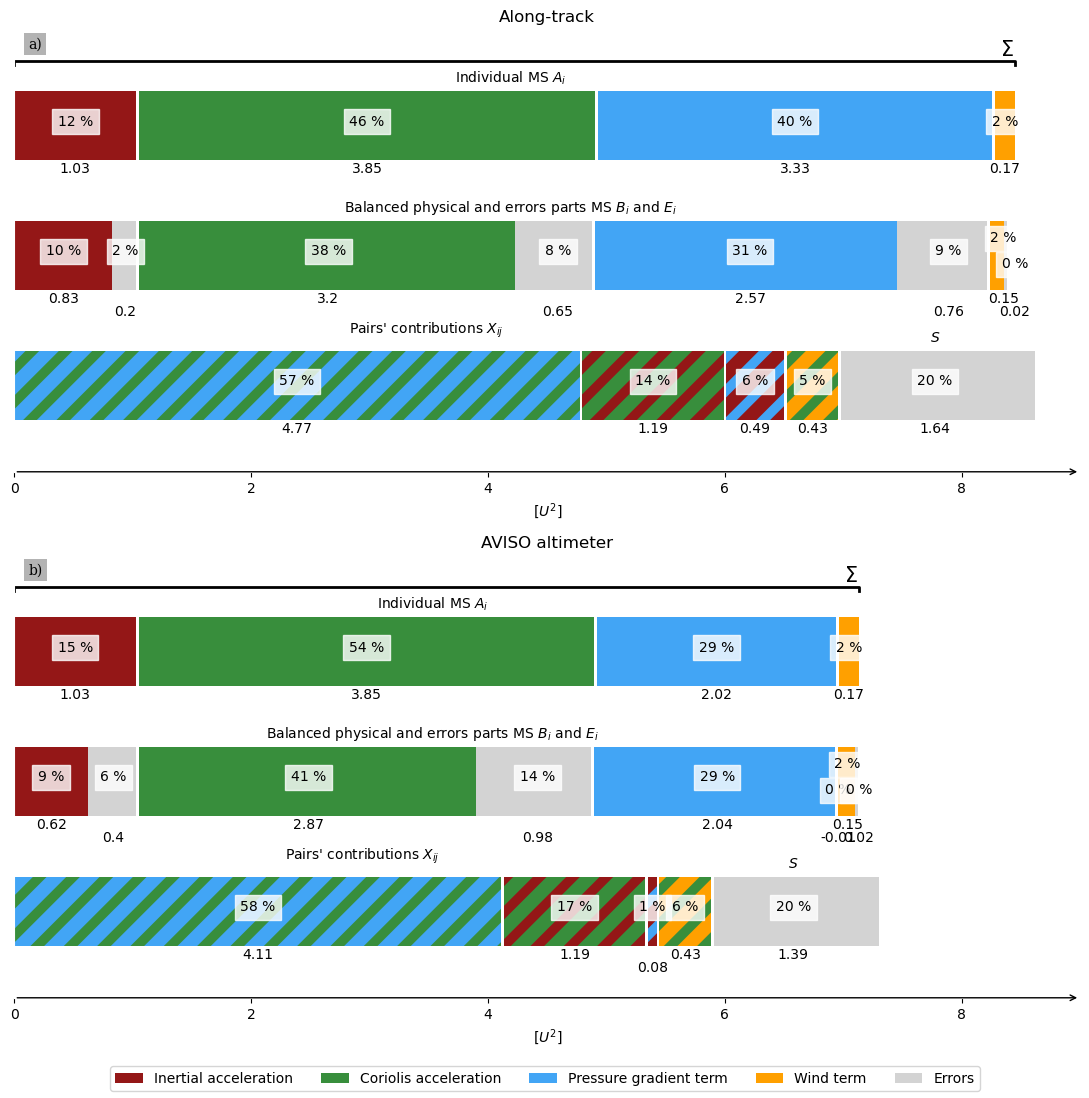

In [50]:
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(11,11), frameon=False, )
plt.rcParams["axes.edgecolor"] = "w"

synthetic_figure(dfalg.value, axs[0], xlim=9) 
synthetic_figure(dfa.value, axs[1], xlim=9, aviso=True) 

axs[0].set_title('Along-track')
axs[1].set_title('AVISO altimeter')

handles, labels = axs[0].get_legend_handles_labels()

put_fig_letter(fig, axs[0], 'a')
put_fig_letter(fig, axs[1], 'b')
fig.legend(handles, labels, ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.03,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/synth_samex_alti.png',bbox_inches='tight',   dpi=300)
#fig.savefig('../images_all/synth_samex_alti.jpeg',bbox_inches='tight',   dpi=300)

8.383810273600547
8.616672494488125
7.029880874668106
ok
7.262493649620944


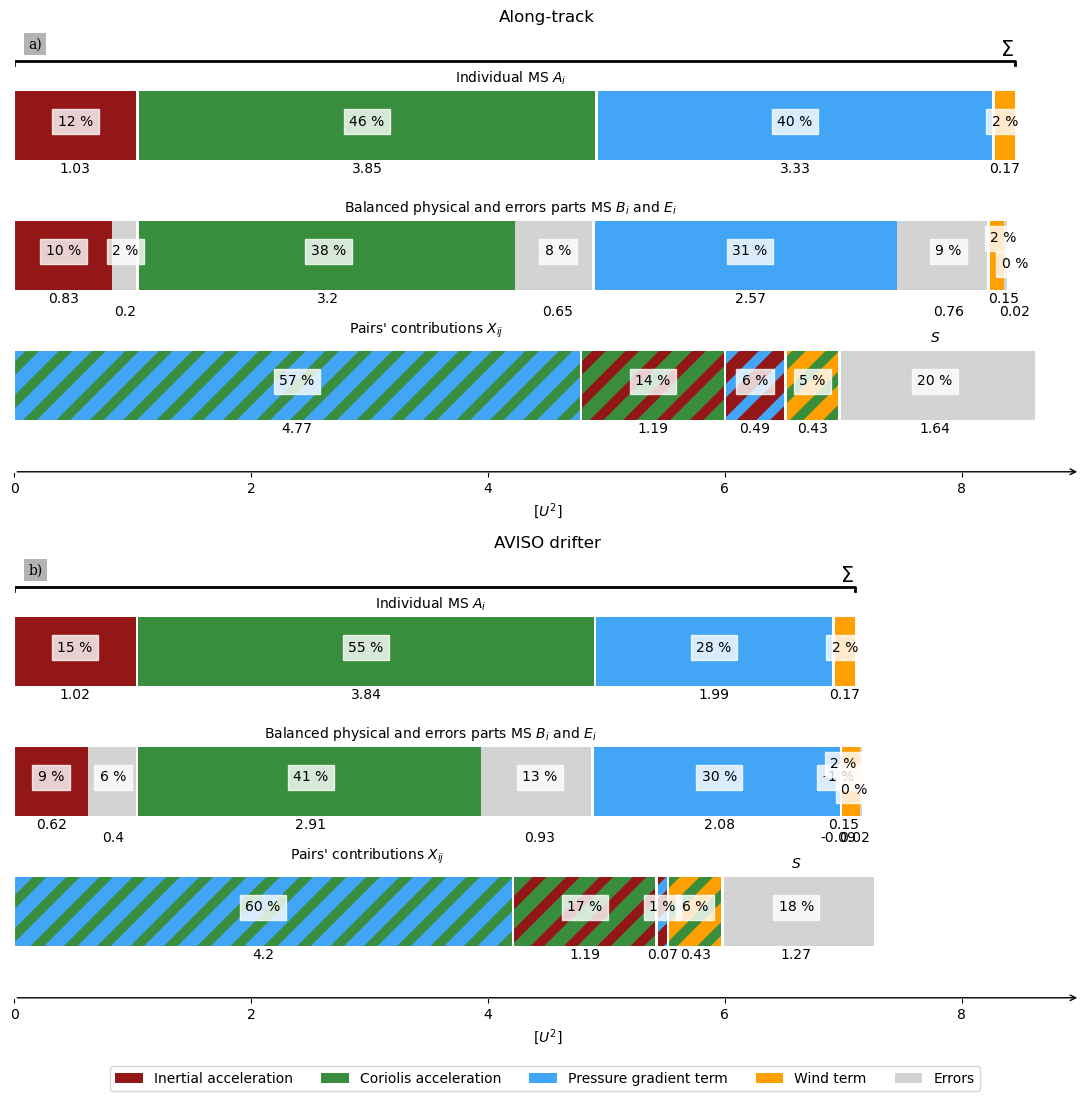

In [55]:
fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(11,11), frameon=False, )
plt.rcParams["axes.edgecolor"] = "w"

synthetic_figure(dfalg.value, axs[0], xlim=9) 
synthetic_figure(dfd.value, axs[1], xlim=9) 

axs[0].set_title('Along-track')
axs[1].set_title('AVISO drifter')

handles, labels = axs[0].get_legend_handles_labels()

put_fig_letter(fig, axs[0], 'a')
put_fig_letter(fig, axs[1], 'b')
fig.legend(handles, labels, ncol=5,loc='lower center')
fig.tight_layout(rect=[0,0.03,1,1])#left, bottom, right, top (default is 0,0,1,1)
#fig.savefig('../images_all/synth_samex.png',bbox_inches='tight',   dpi=300)
#fig.savefig('../images_all/synth_samex.jpeg',bbox_inches='tight',   dpi=300)